# A simple and flexible model for record matching

#### Libraries needed

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_union, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier as Classifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans as Cluster
plt.style.use('fivethirtyeight')

from suricate.lrdftransformers import VectorizerConnector, ExactConnector, FuzzyConnector, VisualHelper
from suricate.preutils import createmultiindex
from suricate.preutils.scores import scores
from suricate.lrdftransformers.cluster import ClusterQuestions, ClusterClassifier
from suricate.pipeline import PipeSbsClf, PruningLrSbsClf, PipeLrClf
from suricate.sbsdftransformers import FuncSbsComparator

#### Load the data

In [5]:
n_rows = 100
from suricate.data.companies import getXlr, getytrue
df_X = getXlr(nrows=n_rows)
left = df_X[0]
right = df_X[1]
y_true = getytrue()
y_true = y_true.loc[
    y_true.index.intersection(createmultiindex(X=df_X))
]
n_possible_pairs= left.shape[0]*right.shape[0]
print('Two datasets of size {} and {}  rows yield:\n {} possible pairs to scan --> manually exhausting'.format(left.shape[0], right.shape[0], n_possible_pairs))
left.sample(5)

Two datasets of size 100 and 100  rows yield:
 10000 possible pairs to scan --> manually exhausting


,name,street,city,postalcode,duns,countrycode
ix,,,,,,
f02cb731-ebe7-4505-af04-61df8df093a5,selex sensos and airborne systems,lg,edinburgh,28000,23226769.0,ES
a30fe96c-51ca-4c9a-add4-8b7e9859cd19,edmund optics inc,lysander close,york,yo30 4xb,236713199.0,GB
8b5d81b9-44a9-44a4-a373-3ce3760a230b,nespresso deutschland gmbh,23 speditionstr,dusseldorf,40221,333868649.0,DE
39734970-79ff-4020-a019-e3b60b6279fc,oracle deutschland gmbh,14 schiffbauergasse,potsdam,14467,33170335.0,DE
8ae6cdb0-5808-4cbb-bb1e-9a6980f8817b,ge sensing,fir tree lane,groby,le6 0fh,219144201.0,GB


# How similar are the records with one another?

#### The framework is fully compatible with open-source Scikit-Learn Machine Learning libraries

In [6]:
scorer = make_union(*[
    VectorizerConnector(on='name', analyzer='word', ngram_range=(1,2)),
     VectorizerConnector(on='name', analyzer='char', ngram_range=(1,2)),
    VectorizerConnector(on='street', analyzer='word', ngram_range=(1,2)),
    VectorizerConnector(on='city', analyzer='char', ngram_range=(1,2)),
    ExactConnector(on='duns'),
    ExactConnector(on='countrycode')
])
imp = SimpleImputer(strategy='constant', fill_value=0)

pca = PCA(n_components=2)
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
t2d = make_pipeline(*[scorer, imp, pca, scaler])

X_score2d = t2d.fit_transform(df_X)

#### Time needed to process the data

In [7]:
# %%timeit
# t2.fit_transform(df_X)

In [8]:
#print('{} pairs processed per second'.format(df_X[0].shape[0]*df_X[1].shape[0] / 8))

### Density plot: how similar are the matches on a 2-d space
Using a sample of maximum 500 lines out of all possible pairs as it is computation intensive

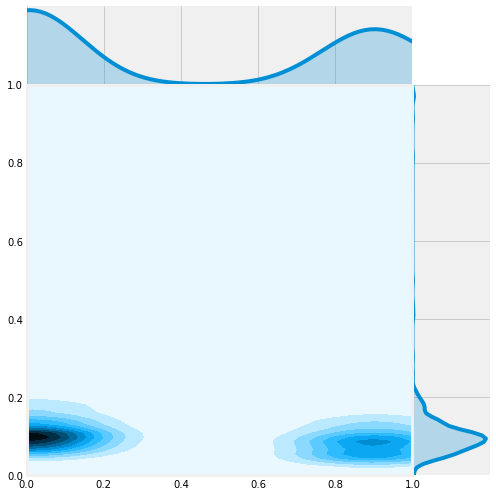

In [9]:
n_samples= np.random.choice(n_possible_pairs, min(500, n_possible_pairs))
X_sample2d = X_score2d[n_samples]
ax = sns.jointplot(X_sample2d[:,0], X_sample2d[:,1], kind="kde", height=7, space=0, xlim=(0,1.0), ylim=(0,1.0))

# Asking hard questions to train the model

### Cluster your data
Support all sklearn clusters

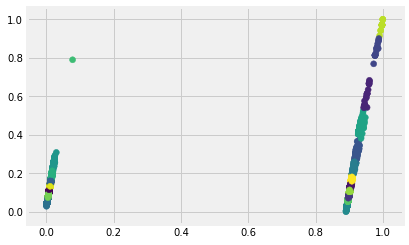

In [10]:
cluster = Cluster(n_clusters=20)
explorer = ClusterQuestions(transformer=t2d, cluster=cluster)
y_cluster = explorer.fit_predict(X=df_X)
plt.scatter(X_score2d[:, 0], X_score2d[:, 1], c=y_cluster);

### Ask representative questions

In [11]:
questions1 = explorer.representative_questions(n_questions=40)
questions1.sort_values(by='similarity').sample(5)

n_questions bigger than size of cluster for cluster 2
n_questions bigger than size of cluster for cluster 4
n_questions bigger than size of cluster for cluster 13
n_questions bigger than size of cluster for cluster 17


,,name_left,name_right,street_left,street_right,city_left,city_right,postalcode_left,postalcode_right,duns_left,duns_right,countrycode_left,countrycode_right,cluster,similarity
ix_left,ix_right,,,,,,,,,,,,,,
fe5db42f-8b19-4295-968a-096fce0df486,7554a1bb-46c5-4af8-9839-8f1a01f54c20,le joint francais,vwr international gmbh,centre administratif,42 whlerstr,thure,hanover,86540,30163,NaN,341869043.0,FR,DE,0,0.007076
35508103-f282-411d-b321-5dbf96d486c7,afac4773-923a-45ce-9d03-54de19231cab,hr kommunikation,parcom gmbh,max von mller s trasse,ewald renz str,rottenburg,bad schonborn,84056,76669,340190931.0,NaN,DE,DE,16,0.902754
4c772645-57f5-490a-a336-b2e4ce1f10d3,3b9f57b4-85af-47be-9530-c553a807f4a3,mewa textil mietservice,sinus electronic,5 hermann gebauer str,schleifweg,meisenheim,untereisesheim,77974,74257,314496969.0,NaN,DE,DE,5,0.919878
8ae6cdb0-5808-4cbb-bb1e-9a6980f8817b,dd1314c3-e23a-4908-a75c-8910d99bb7c9,ge sensing,kuhn albert,fir tree lane,9 wilhelmstr,groby,stuttgart,le6 0fh,70182,219144201.0,NaN,GB,DE,7,0.002803
9438b5e4-21a5-421c-a6aa-559cad3e9674,eef729a2-3311-46d5-85b2-403e417981cf,dichtelemente arcus gmbh,dichtelemente arcus gmbh,6 gromoor ring,16 beckedorfer bogen,hamburg,seevetal,21079,21218,313821894.0,313821894.0,DE,DE,11,0.945300


In [12]:
answer1 = y_true
cluster_composition = explorer.cluster_composition(y=answer1, normalize='index')
cluster_composition

y_true,0,1
cluster,,
1,1.000000,0.000000
2,0.923077,0.076923
3,1.000000,0.000000
4,0.000000,1.000000
5,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000
11,1.000000,0.000000
13,1.000000,0.000000


### Asking more pointed questions on mixed clusters

In [13]:
questions2 = explorer.pointed_questions(y=answer1,n_questions=10)
questions2.sort_values(by='similarity')

n_questions bigger than size of cluster for cluster 2


name_left  \
ix_left                              ix_right                                                                         
150322b3-a3ee-4252-936c-f98ef776bc45 22be1313-c731-4cc8-bc96-2c4cf9b99da6                                 fako gmbh   
816d262e-cf5d-405c-9012-df0053cfd848 aeba4b32-076d-4a65-bbdc-5a94c7bd5e17                    ge measurement control   
7deb146f-57f9-4a7b-b05f-1784c677bdf1 42a5e929-3270-4700-b3c1-08ea755cb894       smiths aerospace electronic systems   
7a60d395-c89b-43ff-9fc1-ce032f99bdcf afac4773-923a-45ce-9d03-54de19231cab                       battery direct gmbh   
536d4a08-8f02-4ec5-9b7d-e02fa09beb6a 501ad89f-f5ce-487d-b5c6-ea6640f79e47                               ge aviation   
6880aa5d-69dd-476f-8883-26d92867022d 42a5e929-3270-4700-b3c1-08ea755cb894                   ge aviation systems ltd   
                                     cce26ebb-988f-4b00-9ef5-c3dc46eb34de                   ge aviation systems ltd   
68ba9560-9ddf-449e-bde2-7ed15604bf18 46bed352-d9d4-4aef-bd97-83309fcc4c54                            frey blumenhof   
8c071814-2bec-4693-b5bc-524d149161f2 501ad89f-f5ce-487d-b5c6-ea6640f79e47  ge aviation systems ltdcustomer services   

                                                                                        name_right  \
ix_left                              ix_right                                                        
150322b3-a3ee-4252-936c-f98ef776bc45 22be1313-c731-4cc8-bc96-2c4cf9b99da6    fako heinrich a anton   
816d262e-cf5d-405c-9012-df0053cfd848 aeba4b32-076d-4a65-bbdc-5a94c7bd5e17            druck limited   
7deb146f-57f9-4a7b-b05f-1784c677bdf1 42a5e929-3270-4700-b3c1-08ea755cb894              ge aviation   
7a60d395-c89b-43ff-9fc1-ce032f99bdcf afac4773-923a-45ce-9d03-54de19231cab              parcom gmbh   
536d4a08-8f02-4ec5-9b7d-e02fa09beb6a 501ad89f-f5ce-487d-b5c6-ea6640f79e47  ge aviation systems ltd   
6880aa5d-69dd-476f-8883-26d92867022d 42a5e929-3270-4700-b3c1-08ea755cb894              ge aviation   
                                     cce26ebb-988f-4b00-9ef5-c3dc46eb34de              ge aviation   
68ba9560-9ddf-449e-bde2-7ed15604bf18 46bed352-d9d4-4aef-bd97-83309fcc4c54           blumenhof frey   
8c071814-2bec-4693-b5bc-524d149161f2 501ad89f-f5ce-487d-b5c6-ea6640f79e47  ge aviation systems ltd   

                                                                                street_left  \
ix_left                              ix_right                                                 
150322b3-a3ee-4252-936c-f98ef776bc45 22be1313-c731-4cc8-bc96-2c4cf9b99da6          peutestr   
816d262e-cf5d-405c-9012-df0053cfd848 aeba4b32-076d-4a65-bbdc-5a94c7bd5e17     fir tree lane   
7deb146f-57f9-4a7b-b05f-1784c677bdf1 42a5e929-3270-4700-b3c1-08ea755cb894        cheltenham   
7a60d395-c89b-43ff-9fc1-ce032f99bdcf afac4773-923a-45ce-9d03-54de19231cab    ewald renz str   
536d4a08-8f02-4ec5-9b7d-e02fa09beb6a 501ad89f-f5ce-487d-b5c6-ea6640f79e47        arle court   
6880aa5d-69dd-476f-8883-26d92867022d 42a5e929-3270-4700-b3c1-08ea755cb894        arle court   
                                     cce26ebb-988f-4b00-9ef5-c3dc46eb34de        arle court   
68ba9560-9ddf-449e-bde2-7ed15604bf18 46bed352-d9d4-4aef-bd97-83309fcc4c54  mittenheimer str   
8c071814-2bec-4693-b5bc-524d149161f2 501ad89f-f5ce-487d-b5c6-ea6640f79e47      evesham road   

                                                                                         street_right  \
ix_left                              ix_right                                                           
150322b3-a3ee-4252-936c-f98ef776bc45 22be1313-c731-4cc8-bc96-2c4cf9b99da6                     sderstr   
816d262e-cf5d-405c-9012-df0053cfd848 aeba4b32-076d-4a65-bbdc-5a94c7bd5e17               fir tree lane   
7deb146f-57f9-4a7b-b05f-1784c677bdf1 42a5e929-3270-4700-b3c1-08ea755cb894                  cheltenham   
7a60d395-c89b-43ff-9fc1-ce032f99bdcf afac4773-923a-45ce-9d03-54de19231cab              ewald renz str 

In [14]:
answer2 = y_true
cluster_composition = explorer.cluster_composition(y=y_true, normalize='index').sort_values(by=1, ascending=False)
cluster_composition

y_true,0,1
cluster,,
4,0.000000,1.000000
17,0.000000,1.000000
2,0.923077,0.076923
1,1.000000,0.000000
3,1.000000,0.000000
5,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000
11,1.000000,0.000000


### Scatter plot using labelled data

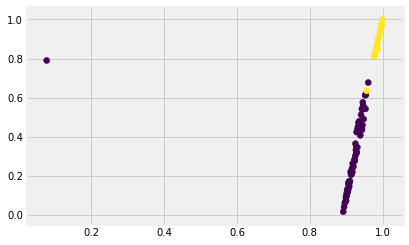

In [15]:
Xpd = pd.DataFrame(data=X_score2d, index=createmultiindex(df_X))
on_ix = y_true.index.intersection(Xpd.index)
plt.scatter(Xpd.loc[on_ix, 0], Xpd.loc[on_ix, 1], c=y_true.loc[on_ix]);

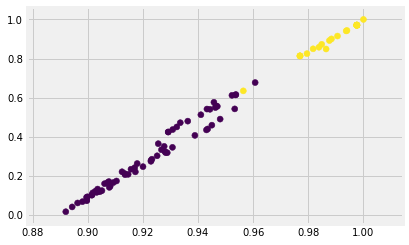

In [16]:
# we remove the outlier to zoom on the separation frontier
on_ix2 = on_ix.drop(Xpd.loc[on_ix, 0].idxmin())
plt.scatter(Xpd.loc[on_ix2, 0], Xpd.loc[on_ix2, 1], c=y_true.loc[on_ix2]);

# Make prediction using training data

### We use the cluster classifier to deal the data in 3 parts:
With the similarity matrix from the (left, right) comparators such defined, the clustering done, and the training data, we can thus categorize the clusters in three groups
- the clusters where there is no positive matches in the training data and where all the pairs are surely not a match (the vast majority of them)
- the clusters where there is only positive matches and where we are pretty confident that these are real matches
- the clusters where there is a mixed of positive and negative samples and where we need further comparators and more intelligent classifiers to take a decision

The ClusterClassifier, using the similarity matrix and the training data, gives the following predictions:
- 0 for sure non matches
- 1 for uncertain matches
- 2 for sure matches

### Repartition of the clusters in terms of proportion

In [17]:
clf1 = ClusterClassifier(cluster=cluster)
clf1.fit(X=Xpd.loc[on_ix], y=y_true)
y_pred_lr = pd.Series(clf1.predict(X=X_score2d), index= createmultiindex(df_X))
y_pred_lr.value_counts()/y_pred_lr.shape[0]

0    0.9951
2    0.0042
1    0.0007
dtype: float64

### We can pipeline the transformer Left Right and the classifier using a class called PipeLrClf

In [18]:
lrmodel = PipeLrClf(transformer=t2d, classifier=clf1)
# lr model has fit and predict capabilities

### Pruning the data
Concentrating on the 2% of mixed matches for further analysis and classifying 98% of the possible pairs is called pruning. It helps a lot reduce the number of comparisons done (in-depth comparison are much more memory-intense)

### Doing further analysis
We bring in new comparators, with compare the dataframe on a side-by-side basis. They use in particular the famous FuzzyWuzzy Library using the Levenshtein distance. Moreover, we can bring any classifier we want from scikit-learn supervised machine learning libraries. We Pipe SbsComparators and Classifier using a clas called PipeSbsClf

In [19]:
transformer2 = make_union(*[
    FuncSbsComparator(on='name', comparator='fuzzy'),
    FuncSbsComparator(on='name', comparator='token'),
    FuncSbsComparator(on='street', comparator='fuzzy'),
    FuncSbsComparator(on='city', comparator='fuzzy'),
    FuncSbsComparator(on='postalcode', comparator='fuzzy'),

])
imp2 = SimpleImputer(strategy='constant', fill_value=0)
pca3 = PCA(n_components=3)
transformer2 = make_pipeline(*[transformer2, imp2, pca3])
clf2 = Classifier()
sbsmodel = PipeSbsClf(transformer=transformer2, classifier=clf2)

### Pipelining the two steps above
This is done using a class Called aptly PruningLrSbsClf

In [20]:
pipe = PruningLrSbsClf(lrmodel=lrmodel, sbsmodel=sbsmodel)
pipe.fit(X=df_X, y_lr=y_true, y_sbs=y_true)
y_pred = pd.Series(
    data=pipe.predict(X=df_X),
    index=createmultiindex(X=df_X),
    name='y_pred'
)
y_pruning = pd.Series(data=np.where(y_pred_lr >1, 1, y_pred_lr), index= createmultiindex(X=df_X))
pruningscores = scores(y_true=y_true, y_pred=y_pruning)
finalscores = scores(y_true=y_true, y_pred=y_pred)
for c in pruningscores.keys():
    print('\n {}\n pruning:{}\nfinal{}\n'.format(c, pruningscores[c], finalscores[c]))


 precision
 pruning:0.9090909090909091
final1.0


 recall
 pruning:1.0
final1.0


 f1
 pruning:0.9523809523809523
final1.0


 accuracy
 pruning:0.97
final1.0


 balanced_accuracy
 pruning:0.9785714285714286
final1.0



# Visualizing the possible matches
This is done via a class called VisualHelper. Useful to export to excel

In [21]:
viz = VisualHelper()
goodmatches= y_pred.loc[y_pred==1].index
sbs = viz.transform(X=df_X, on_ix=goodmatches, usecols=['name', 'street', 'city', 'postalcode', 'countrycode'])
sbs['confidence'] = y_pred_lr.loc[goodmatches]
sbs.reset_index(drop=False, inplace=True)

#### matches with very high confidence

In [22]:
sbs.loc[(sbs['confidence']==2) & (sbs['ix_left']!=sbs['ix_right'])].sample(5)

,ix_left,ix_right,name_left,name_right,street_left,street_right,city_left,city_right,postalcode_left,postalcode_right,countrycode_left,countrycode_right,confidence
40,9b938f7e-ce01-4623-815f-099ce1097edd,31977c06-ae68-4fa8-a5ad-470ffafca635,siemens ag,siemens ag,16 sieboldstr,16 hartmannstr,erlangen,erlangen,91052,91052,DE,DE,2
16,77f5274a-b8ab-45bc-ae41-2e1f6c06e51c,b54f1933-d136-45b9-8bf9-da9d7f69c096,selex es spa,selex es spa,via piemonte,via piemonte,rome,rome,187,187,IT,IT,2
32,f0d34671-a63e-4a7a-a0fd-91de34614366,253ce464-33bd-41cc-a078-81f262216c45,hamilton sundstrand,hamilton sundstrand,cl4747 harrison ave,4747 harrison ave,rockford,rockford,61125,61108-7929,US,US,2
22,8c071814-2bec-4693-b5bc-524d149161f2,cce26ebb-988f-4b00-9ef5-c3dc46eb34de,ge aviation systems ltdcustomer services,ge aviation,evesham road,evesham road,cheltenham,cheltenham,gl528sf,gl52 8sf,GB,GB,2
27,1d2e777b-15af-403c-9b9d-b16819dceda3,f8db7942-610b-445d-a299-c4ae23c45217,citaku gbr,citaku gbr,32 papenbreede,32 papenbreede,bad essen,bad essen,49152,49152,DE,DE,2


#### probable matches

In [23]:
sbs.loc[(sbs['confidence']==1)].sample(5)

ValueError: Cannot take a larger sample than population when 'replace=False'